In [5]:
import torch 
torch.manual_seed(12345)
from torch import nn
import dsntnn
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
        )
    def forward(self, x):
        return self.layers(x)

In [6]:
class CoordRegressionNetwork(nn.Module):
    def __init__(self, n_locations):
        super().__init__()
        self.fcn = FCN()
        self.hm_conv = nn.Conv2d(16, n_locations, kernel_size=1, bias=False)
 
    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)
 
        return coords, heatmaps

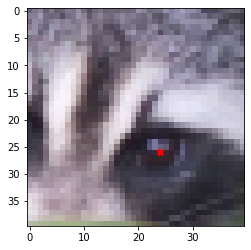

In [3]:
from torch import optim
import matplotlib.pyplot as plt
import scipy
import scipy.misc as sm
import numpy as np
from skimage.transform import resize
 
image_size = [40, 40]
#raccoon_face = sm.imresize(scipy.misc.face()[200:400, 600:800, :], image_size)  # (40, 40, 3)
#无需降级scipy，解决AttributeError: module ‘scipy.misc’ has no attribute ‘imread’，imresize，imsave问题
#https://blog.csdn.net/huang1024rui/article/details/119668502
raccoon_face = resize(scipy.misc.face()[200:400, 600:800, :],output_shape=image_size)
eye_x, eye_y = 24, 26
 
plt.imshow(raccoon_face)
plt.scatter([eye_x], [eye_y], color='red', marker='X')
plt.show()

由于DSNT输出的坐标范围是(-1, 1)，所以需要将target的坐标也归一化到这个范围

In [7]:
raccoon_face_tensor = torch.from_numpy(raccoon_face).permute(2, 0, 1).float()  # torch.Size([3, 40, 40])
input_tensor = raccoon_face_tensor.div(255).unsqueeze(0)  # torch.Size([1, 3, 40, 40])
input_var = input_tensor.cuda()
 
eye_coords_tensor = torch.Tensor([[[eye_x, eye_y]]])  # shape = [1, 1, 2],value=[[[24., 26.]]]

#由于DSNT输出的坐标范围是(-1, 1)，所以需要将target的坐标也归一化到这个范围
target_tensor = (eye_coords_tensor * 2 + 1) / torch.Tensor(image_size) - 1  # shape = [1, 1, 2],value=[[[0.2250, 0.3250]]]
target_var = target_tensor.cuda()
 
print('Target: {:0.4f}, {:0.4f}'.format(*list(target_tensor.squeeze())))

Target: 0.2250, 0.3250


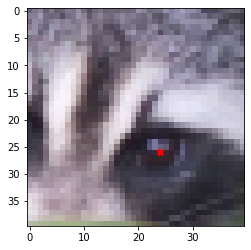

Target: 0.2250, 0.3250
Predicted coords: 0.2276, 0.3213


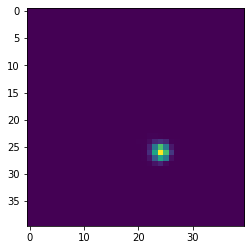

In [9]:
import scipy
import scipy.misc as sm
import matplotlib.pyplot as plt
import torch
torch.manual_seed(12345)
from torch import nn
import dsntnn
import torch.optim as optim
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
        )
    def forward(self, x):
        return self.layers(x)
class CoordRegressionNetwork(nn.Module):
    def __init__(self, n_locations):
        super().__init__()
        self.fcn = FCN()
        self.hm_conv = nn.Conv2d(16, n_locations, kernel_size=1, bias=False)
    def forward(self, images):
        # 1. Run the images through our FCN
        fcn_out = self.fcn(images)
        # 2. Use a 1x1 conv to get one unnormalized heatmap per location
        unnormalized_heatmaps = self.hm_conv(fcn_out)
        # 3. Normalize the heatmaps
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        # 4. Calculate the coordinates
        coords = dsntnn.dsnt(heatmaps)
        return coords, heatmaps
image_size = [40, 40]
#raccoon_face = sm.imresize(scipy.misc.face()[200:400, 600:800, :], image_size)      # (40, 40, 3)
raccoon_face = resize(scipy.misc.face()[200:400, 600:800, :], image_size)      # (40, 40, 3)
eye_x, eye_y = 24, 26
plt.imshow(raccoon_face)
plt.scatter([eye_x], [eye_y], color='red', marker='X')
plt.show()
raccoon_face_tensor = torch.from_numpy(raccoon_face).permute(2, 0, 1).float()   # torch.Size([3, 40, 40])
input_tensor = raccoon_face_tensor.div(255).unsqueeze(0)    # torch.Size([1, 3, 40, 40])
input_var = input_tensor.cuda()
eye_coords_tensor = torch.Tensor([[[eye_x, eye_y]]])    # # shape = [1, 1, 2],value=[[[24., 26.]]]
target_tensor = (eye_coords_tensor * 2 + 1) / torch.Tensor(image_size) - 1  # shape = [1, 1, 2],value=[[[0.2250, 0.3250]]]
target_var = target_tensor.cuda()
print('Target: {:0.4f}, {:0.4f}'.format(*list(target_tensor.squeeze())))
model = CoordRegressionNetwork(n_locations=1).cuda()    # n_locations=keypoint num=1
# coords, heatmaps = model(input_var)
# print('Initial prediction: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
# plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
# plt.show()
optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)
for i in range(400):
    # Forward pass
    coords, heatmaps = model(input_var)
    # coords:shape=[1, 1, 2], value=[[[0.0323, 0.0566]]]; heatmaps:shape=[1, 1, 40, 40]
    # Per-location euclidean losses
    euc_losses = dsntnn.euclidean_losses(coords, target_var)
    # Per-location regularization losses
    reg_losses = dsntnn.js_reg_losses(heatmaps, target_var, sigma_t=1.0)
    # Combine losses into an overall loss
    loss = dsntnn.average_loss(euc_losses + reg_losses)
    # Calculate gradients
    optimizer.zero_grad()
    loss.backward()
    # Update model parameters with RMSprop
    optimizer.step()
# Predictions after training
print('Predicted coords: {:0.4f}, {:0.4f}'.format(*list(coords[0, 0])))
plt.imshow(heatmaps[0, 0].detach().cpu().numpy())
plt.show()

In [65]:
xy_tensor = coords.detach().cpu()
xy = (((xy_tensor + 1) * torch.Tensor(image_size)) - 1 )/ 2
print(xy[0,0].shape)
print('Predicted coords: {:0.4f}, {:0.4f}'.format(*list(xy[0, 0])))

torch.Size([2])
Predicted coords: 24.0519, 25.9265
